In [116]:
import pandas as pd
# Wczytanie danych
# data = pd.read_csv('sms_spam.csv') # BŁĄD

In [14]:
# chardet - wbudowany moduł Pythona do rozpoznawania znaków, kodowania, języka w plikach binarnych
import chardet

file = "sms_spam.csv"
with open(file, 'rb') as f:
    char_specification = chardet.detect( f.read() )
    print(char_specification)
    print(char_specification["encoding"])

{'encoding': 'Windows-1252', 'confidence': 0.7257971165545478, 'language': ''}
Windows-1252


In [29]:
# Wczytanie danych z kodowaniem
df = pd.read_csv('sms_spam.csv', encoding="Windows-1252")

# df.head(10)
df = df[ ["v1", "v2"] ]
df.head(10)

# Przydatne:
# df.info()
# df.describe()
# df["v1"].value_counts() # liczby
# df["v1"].value_counts(normalize=True) * 100  # procenty

v1                                                 v2
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
5  spam  FreeMsg Hey there darling it's been 3 week's n...
6   ham  Even my brother is not like to speak with me. ...
7   ham  As per your request 'Melle Melle (Oru Minnamin...
8  spam  WINNER!! As a valued network customer you have...
9  spam  Had your mobile 11 months or more? U R entitle...

In [38]:
# Podział danych na zbiór trenujący i testowy (proporcje 90/10)
from sklearn.model_selection import train_test_split

data = df['v2'] # od czego zalezy (X)
labels = df['v1'] # wynik (Y)
train_data, test_data, train_labels, test_labels = train_test_split(X, Y, test_size=0.1, random_state=666)

# Warto zerknąć przed dalszą analizą - % wybranych danych przy takim zbiorze może wpływać na wyniki
train_labels.value_counts(normalize=True) * 100
test_labels.value_counts(normalize=True) * 100

ham     88.351254
spam    11.648746
Name: v1, dtype: float64

In [94]:
# Analiza danych tekstowych 
from sklearn.feature_extraction.text import CountVectorizer

# Podział na macierze z częstością występowania danych słów
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_data)
X_test = vectorizer.transform(test_data)

# Dostajemy macierze z częstością występowania danych słów - na tej podstawie będziemy ustalać warunki,
# np. najprościej: sms zawiera słowo "congratulations" - jeśli wystąpiło ono w 90% smsów zaklasyfikowanych jako spam,
# to jest 90% szansy, że sms zawierający słowo "congratulations" będzie spamem.

# Sposób na podejrzenie danych (spokojnie, nikt normalny by tego nie napisał z głowy!)
X_train_dense = pd.DataFrame(X_train.todense(), columns=vectorizer.get_feature_names_out()) 
X_train_dense # nic nie widać, wszystkie randomowe zlepki znaków
# Zostawiamy tylko kolumny, które składają się z prostych liter (czyli mogą być prawdziwymi słowami a nie zlepkami znaków)
# Zostawiamy tylko te, mające 10 znaków (słowa 15-znakowe)
# Zostawiamy 5 pierwszych z nich
selected_columns_train = X_train_dense.filter(regex=r'\b[a-zA-Z]{15}\b').iloc[:, :5]
selected_columns_train # tutaj dalej nic raczej nie zobaczymy, bo za duży zbiór danych
# filtrowanie warunkowe - smsy, które mają w treści "congratulations" (UWAGA! numery ze zbioru treningowego, więc niezwiązane z pierwotnymi!)
sms_with_congratulations = selected_columns_train[ selected_columns_train['congratulations'] > 0 ]
congratulations_sms_content = train_data.iloc[sms_with_congratulations.index]
congratulations_sms_labels = train_labels.iloc[sms_with_congratulations.index]
congratulations_sms_content, congratulations_sms_labels

# W ramach ćwiczenia: wyświetl smsy ze słowem "winner" - które parametry musisz zmienić?

(4575    Congratulations ur awarded 500 of CD vouchers ...
 931     Congratulations ore mo owo re wa. Enjoy it and...
 3826    Congratulations U can claim 2 VIP row A Ticket...
 1422    Congratulations ur awarded either å£500 of CD ...
 2123    +123 Congratulations - in this week's competit...
 356     Congratulations ur awarded 500 of CD vouchers ...
 2311    Congratulations! Thanks to a good friend U hav...
 3596    Congratulations YOU'VE Won. You're a Winner in...
 5002    CDs 4u: Congratulations ur awarded å£500 of CD...
 2824    Congratulations - Thanks to a good friend U ha...
 812     Congratulations ur awarded either å£500 of CD ...
 865     Congratulations ur awarded either a yrs supply...
 3258    Congratulations! Thanks to a good friend U hav...
 504     +123 Congratulations - in this week's competit...
 249     Congratulations ur awarded 500 of CD vouchers ...
 Name: v2, dtype: object,
 4575    spam
 931      ham
 3826    spam
 1422    spam
 2123    spam
 356     spam
 2311

In [101]:
# Użycie naiwnego klasyfikatora Bayesa
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB()
classifier.fit(X_train, train_labels)
predicted_labels = classifier.predict(X_test)

# Charakterystyka naszych danych tekstowych (częstość występowania słów) powoduje, że stosujemy MultinomialNB
# Dla danych binarnych (0,1) stosuje się BernoulliNB, a dla danych ciągłych z rozkładu normalnego GaussianNB

# Tylko pierwsze 15 prawdziwych i przewidzianych wyników
test_labels[:15], predicted_labels[:15] # wiele jeszcze nie zobaczymy przy naszych danych, ale jest pewna zgodność tendencji

(3757     ham
 2136     ham
 3635     ham
 5325     ham
 1696     ham
 2038     ham
 449      ham
 3493    spam
 4416     ham
 2021     ham
 4140     ham
 2354     ham
 3039     ham
 397      ham
 5460    spam
 Name: v1, dtype: object,
 array(['ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham',
        'ham', 'ham', 'ham', 'ham', 'ham', 'spam'], dtype='<U4'))

In [114]:
# Ocena skuteczności klasyfikatora
from sklearn import metrics
accuracy = metrics.accuracy_score(test_labels, predicted_labels)
accuracy

# Inne metryki skuteczności klasyfikacji: precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Obliczenie ilości danych z każdej klasyfikacji i "ręczne" sprawdzenie czy klasyfikacja jest ok:
print(test_labels.value_counts()) # Pandas Series

import numpy as np
print(np.bincount(np.where(predicted_labels == 'spam', 1, 0))) # Tablica Numpy - nieco bardziej naokoło

#lub prościej
s_pred = pd.Series(predicted_labels)
s_pred.value_counts()

ham     493
spam     65
Name: v1, dtype: int64
[498  60]


ham     498
spam     60
dtype: int64

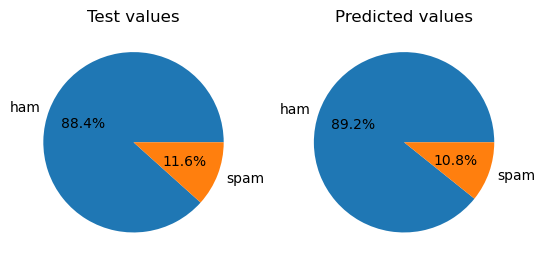

In [130]:
# Wykresy
import matplotlib.pyplot as plt
spam_percent_test = test_labels.value_counts()
spam_percent_pred = pd.Series(predicted_labels).value_counts()

plt.subplot(1,2,1)
plt.title("Test values")
plt.pie(spam_percent_test, labels = spam_percent_test.index, autopct='%1.1f%%')
plt.subplot(1,2,2)
plt.title("Predicted values")
plt.pie(spam_percent_pred, labels = spam_percent_pred.index, autopct='%1.1f%%')
plt.show()

In [138]:
# Wyświetlenie fałszywie pozytywnych i fałszywie negatywnych
# fałszywie pozytywne (czyli zwykłe wiadomości, zaklasyfikowane jako spam
false_positive = test_data[ (test_labels == 'ham') & (predicted_labels == 'spam') ]
print("False positive:")
print(false_positive)
# wniosek: wtedy żadna zwykła wiadomość od kolegi nie trafi do spamu

# fałszywie negatywne (czyli wiadomości ze spamem, które dotrą do użytkownika jako poprawne)
false_negative = test_data[ (test_labels == 'spam') & (predicted_labels == 'ham') ]
print("False negative:")
pd.set_option('display.max_colwidth', None) # Musimy włączyć tą opcję, żeby pokazało całe wiadomości
false_negative
# wniosek: na te wiadomości musimy uważać, bo wyglądają jak od kolegi, a są spamem

False positive:
Series([], Name: v2, dtype: object)
False negative:


4512                                                                                                    Money i have won wining number 946 wot do i do next
3062    Hi babe its Jordan, how r u? Im home from abroad and lonely, text me back if u wanna chat xxSP visionsms.com Text stop to stopCost 150p 08712400603
2963                Do you ever notice that when you're driving, anyone going slower than you is an idiot and everyone driving faster than you is a maniac?
1429                                                                                For sale - arsenal dartboard. Good condition but no doubles or trebles!
1874                                                                   Would you like to see my XXX pics they are so hot they were nearly banned in the uk!
Name: v2, dtype: object

In [147]:
# Zadanie dodatkowe (generowane przez ChatGPT)

# Dane
P_word_spam_xxx = 0.9
P_word_spam_bitcoin = 0.8
P_spam_prior = 0.5
P_word_ham_xxx = 0.1
P_word_ham_bitcoin = 0.1
P_ham_prior = 0.5

# Obliczenia
numerator = P_word_spam_xxx * P_word_spam_bitcoin * P_spam_prior
denominator = (P_word_spam_xxx * P_word_spam_bitcoin * P_spam_prior) + (P_word_ham_xxx * P_word_ham_bitcoin * P_ham_prior)
P_spam_given_words = numerator / denominator

print("Prawdopodobieństwo, że mail jest spamem:", P_spam_given_words)

Prawdopodobieństwo, że mail jest spamem: 0.9863013698630136
